In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from fancyimpute import IterativeImputer
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
description = pd.read_excel('E Commerce Dataset.xlsx',sheet_name='Data Dict', header=1, usecols=[1,2,3])

In [3]:
data = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='E Comm')

In [4]:
description.head()

,Data,Variable,Discerption
0,E Comm,CustomerID,Unique customer ID
1,E Comm,Churn,Churn Flag
2,E Comm,Tenure,Tenure of customer in organization
3,E Comm,PreferredLoginDevice,Preferred login device of customer
4,E Comm,CityTier,City tier


In [5]:
#preview the data
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [6]:
#check the shape of the dataset
print(data.shape)

(5630, 20)


In [7]:
#brief information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [10]:
data.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [8]:
#Audit correctness 
for col in data.columns:
    miss = data[col].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(col,miss))
    else:
        print("{} has NO missing value!".format(col))
        

CustomerID has NO missing value!
Churn has NO missing value!
Tenure has 264 missing value(s)
PreferredLoginDevice has NO missing value!
CityTier has NO missing value!
WarehouseToHome has 251 missing value(s)
PreferredPaymentMode has NO missing value!
Gender has NO missing value!
HourSpendOnApp has 255 missing value(s)
NumberOfDeviceRegistered has NO missing value!
PreferedOrderCat has NO missing value!
SatisfactionScore has NO missing value!
MaritalStatus has NO missing value!
NumberOfAddress has NO missing value!
Complain has NO missing value!
OrderAmountHikeFromlastYear has 265 missing value(s)
CouponUsed has 256 missing value(s)
OrderCount has 258 missing value(s)
DaySinceLastOrder has 307 missing value(s)
CashbackAmount has NO missing value!


In [10]:
#print summary statistics of the data including the categorical columns
data.describe(include='all')

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630,5630.000000,5379.000000,5630,5630,5375.000000,5630.000000,5630,5630.000000,5630,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
unique,NaN,NaN,NaN,3,NaN,NaN,7,2,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Mobile Phone,NaN,NaN,Debit Card,Male,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2765,NaN,NaN,2314,3384,NaN,NaN,2050,NaN,2986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,52815.500000,0.168384,10.189899,NaN,1.654707,15.639896,NaN,NaN,2.931535,3.688988,NaN,3.066785,NaN,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,NaN,0.915389,8.531475,NaN,NaN,0.721926,1.023999,NaN,1.380194,NaN,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,NaN,1.000000,5.000000,NaN,NaN,0.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,NaN,1.000000,9.000000,NaN,NaN,2.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,NaN,1.000000,14.000000,NaN,NaN,3.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,NaN,3.000000,20.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500


In [11]:
data['churn status'] = np.where(data['Churn']!=0 , 'Churned', 'Not Churned')

In [12]:
#data=data.iloc[:,:-1]

In [13]:
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,churn status
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,2,Single,9,1,11.0,1.0,1.0,5.0,159.93,Churned
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,...,3,Single,7,1,15.0,0.0,1.0,0.0,120.90,Churned
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,...,3,Single,6,1,14.0,0.0,1.0,3.0,120.28,Churned
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,...,5,Single,8,0,23.0,0.0,1.0,3.0,134.07,Churned
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,...,5,Single,3,0,11.0,1.0,1.0,3.0,129.60,Churned


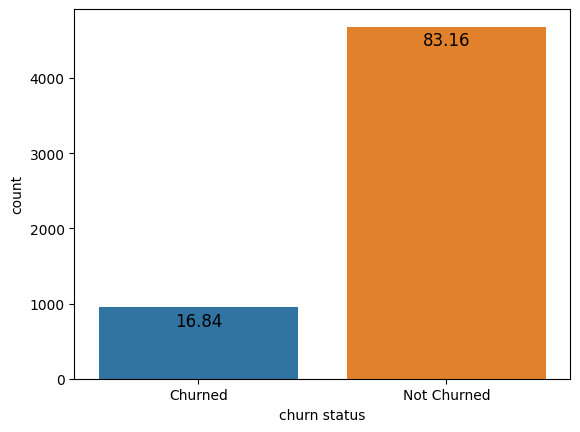

In [14]:
ax = sns.countplot(x='churn status', data=data)
for a in ax.patches:
    ax.annotate(format((a.get_height()/5630)*100,'.2f'), (a.get_x() + a.get_width()/2., a.get_height()),\
                ha='center',va='center',size=12,xytext=(0, -10),textcoords='offset points')
plt.show()

There are more retained than churned customers, the ratio of retained to churned is approximately 5 to 1, so the churn rate is very low, which is normal therefore making the data imbalanced.

# Distribution of the Tenure of the customers on the platform

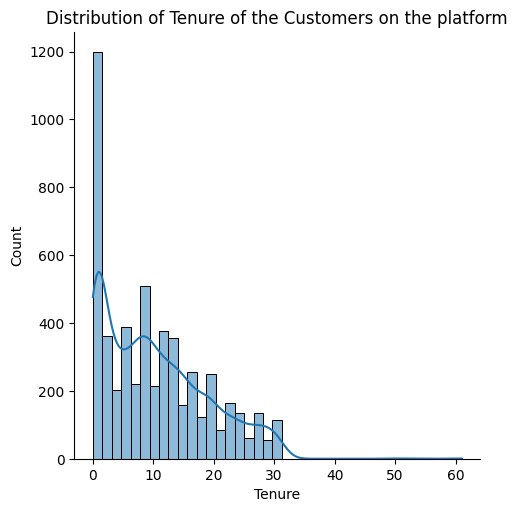

In [20]:
sns.displot(x='Tenure', kde=True, data=data)
plt.title("Distribution of Tenure of the Customers on the platform")
plt.show()

### Distribution of Recency of the customers
Recency is gotten from the day since last order of each customer. Customers with low number of days since last order are recent customers and vice versa

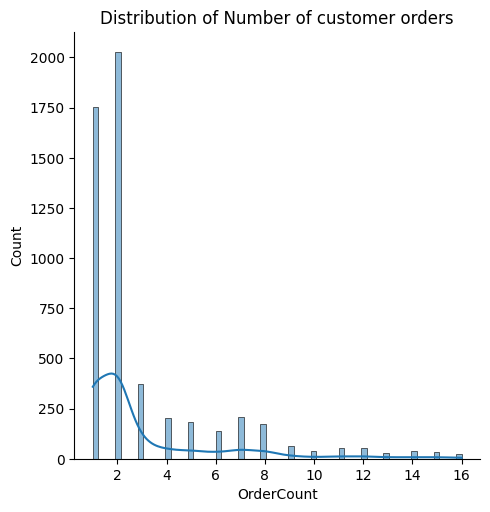

In [21]:
sns.displot(x='OrderCount', kde=True, data=data)
plt.title("Distribution of Number of customer orders")
plt.show()

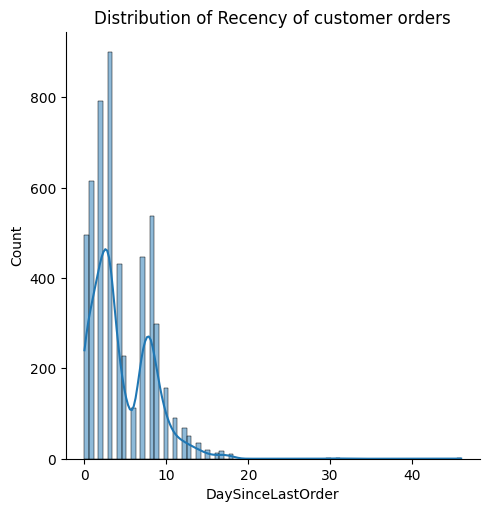

In [22]:

sns.displot(x='DaySinceLastOrder', kde=True, data=data)
plt.title("Distribution of Recency of customer orders")
plt.show()

### Distribution of Amount returned for money spent by customers



Cashback is a reward that refunds a percentage of the money spent to by a customer to him/her, It is usually dependent on the amount spent, so the cashback column can be used in place of the amount spent columns.

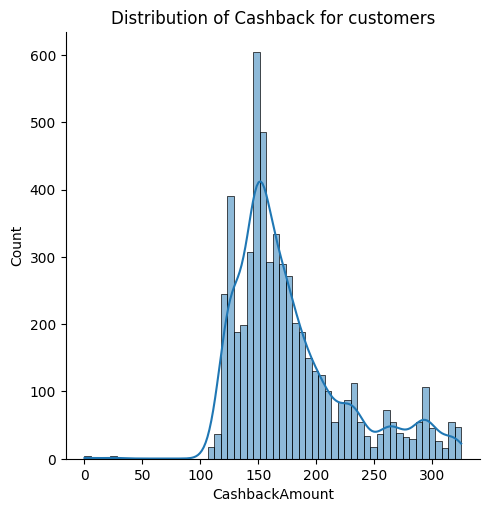

In [23]:
sns.displot(x='CashbackAmount',kde=True, data=data)
plt.title('Distribution of Cashback for customers')
plt.show()


### Distribution of distance of Warehouse to customers home

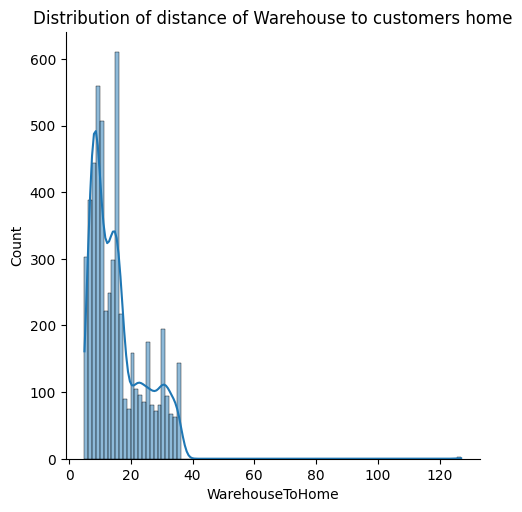

In [24]:
sns.displot(x='WarehouseToHome', kde=True, data=data)
plt.title("Distribution of distance of Warehouse to customers home")
plt.show()

### Distribution of Percentage increase in customer orders

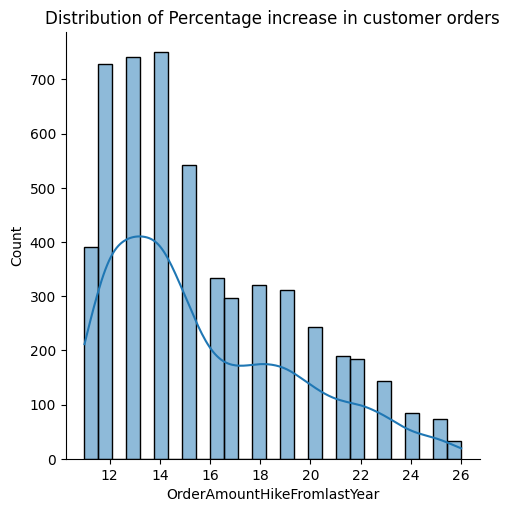

In [25]:
sns.displot(x='OrderAmountHikeFromlastYear', kde=True, data=data)
plt.title("Distribution of Percentage increase in customer orders")
plt.show()

### Distribution of Hours spent on the app by the customers

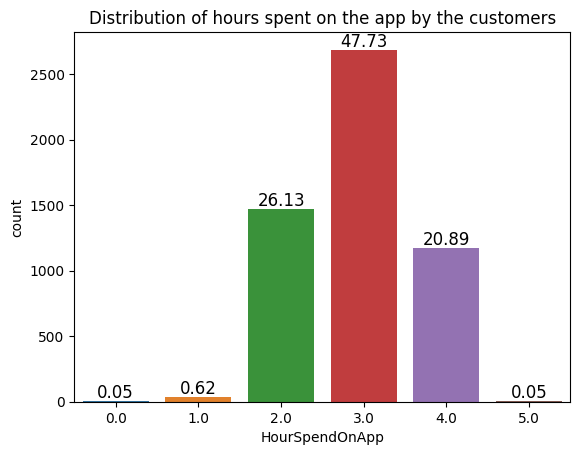

In [26]:
axx = sns.countplot(x='HourSpendOnApp', data=data)
for a in axx.patches:
    axx.annotate(format((a.get_height()/5630)*100,'.2f'), (a.get_x() + a.get_width()/2., a.get_height()),\
                ha='center',va='center',size=12,xytext=(0, 6),textcoords='offset points')
plt.title("Distribution of hours spent on the app by the customers")
plt.show()

### Distribution Satisfaction score for churned and retained customers

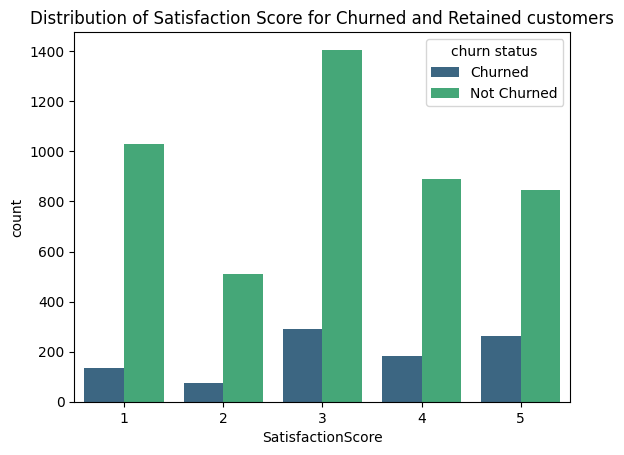

In [27]:
sns.countplot(x='SatisfactionScore', hue='churn status', palette='viridis', data=data)
plt.title("Distribution of Satisfaction Score for Churned and Retained customers")
plt.show()

### Distribution of Gender for churned and retained customers

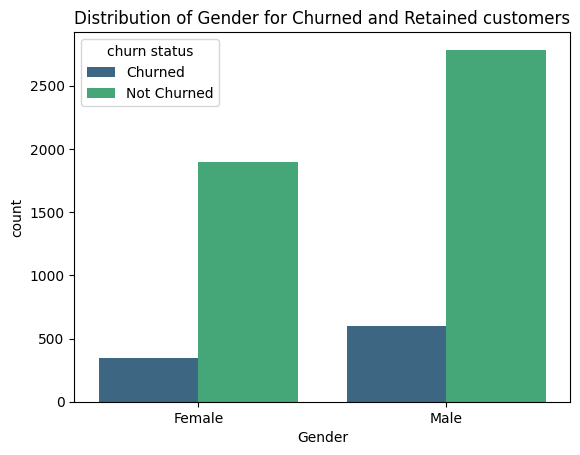

In [28]:
sns.countplot(x='Gender', hue='churn status', palette='viridis', data=data)
plt.title("Distribution of Gender for Churned and Retained customers")
plt.show()

### Distribution of marital status for churned and retained customers

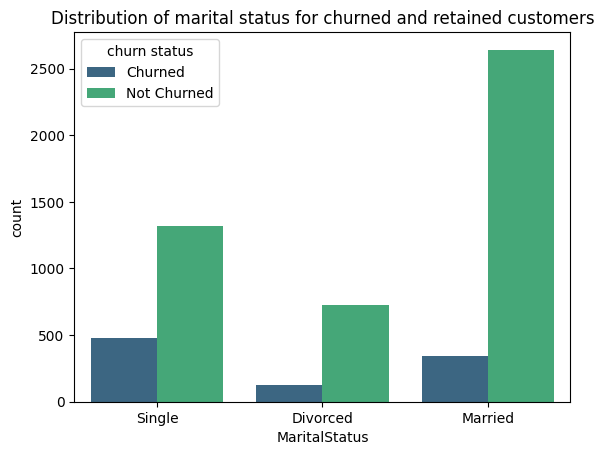

In [29]:
sns.countplot(x='MaritalStatus', hue='churn status', palette='viridis', data=data)
plt.title("Distribution of marital status for churned and retained customers")
plt.show()

### Distribution of complain for churned and retained customers

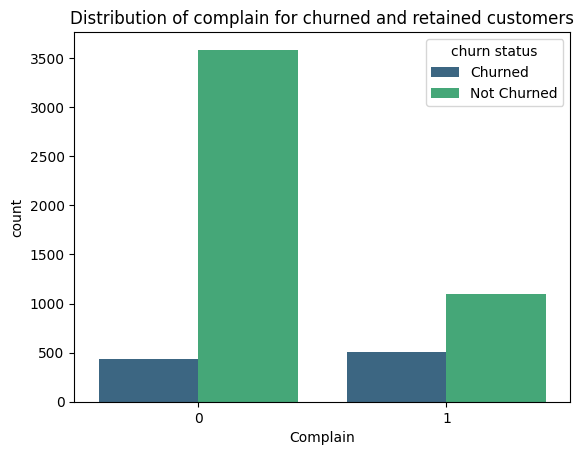

In [30]:
sns.countplot(x='Complain', hue='churn status', palette='viridis', data=data)
plt.title("Distribution of complain for churned and retained customers")
plt.show()

### Relationship between the Tenure and Churn rate

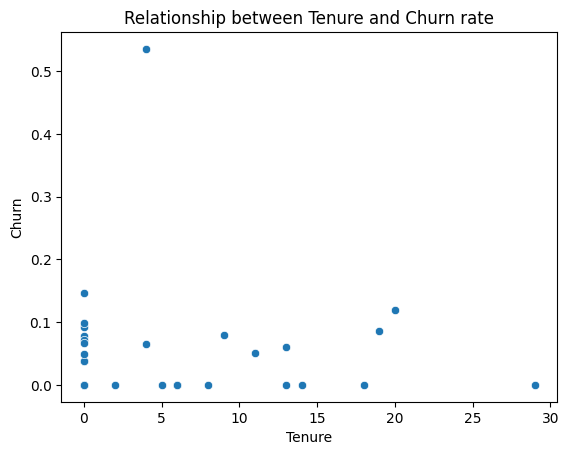

In [31]:
sns.scatterplot(x=data['Tenure'],y=data.groupby('Tenure').Churn.mean())
plt.title("Relationship between Tenure and Churn rate")
plt.show()

### Relationship between the Order Count and Churn rate

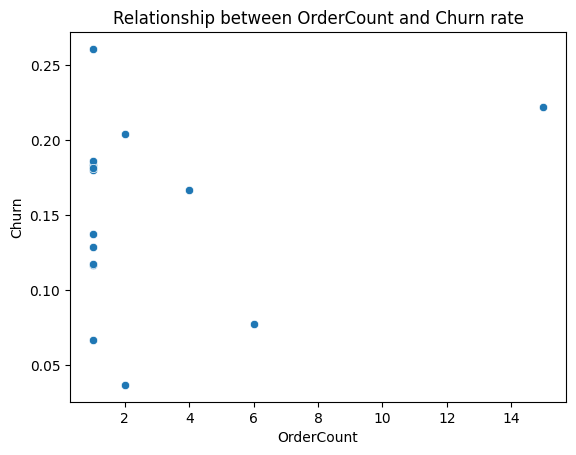

In [32]:
sns.scatterplot(x=data['OrderCount'],y=data.groupby('OrderCount').Churn.mean())
plt.title("Relationship between OrderCount and Churn rate")
plt.show()

### Relationship between the Coupon Used and Churn rate

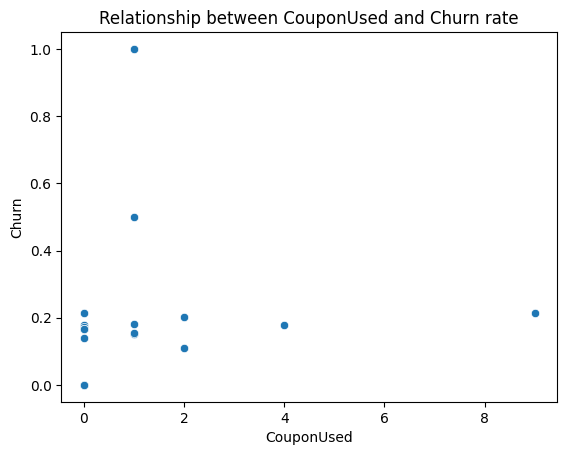

In [33]:
sns.scatterplot(x=data['CouponUsed'],y=data.groupby('CouponUsed').Churn.mean())
plt.title("Relationship between CouponUsed and Churn rate")
plt.show()

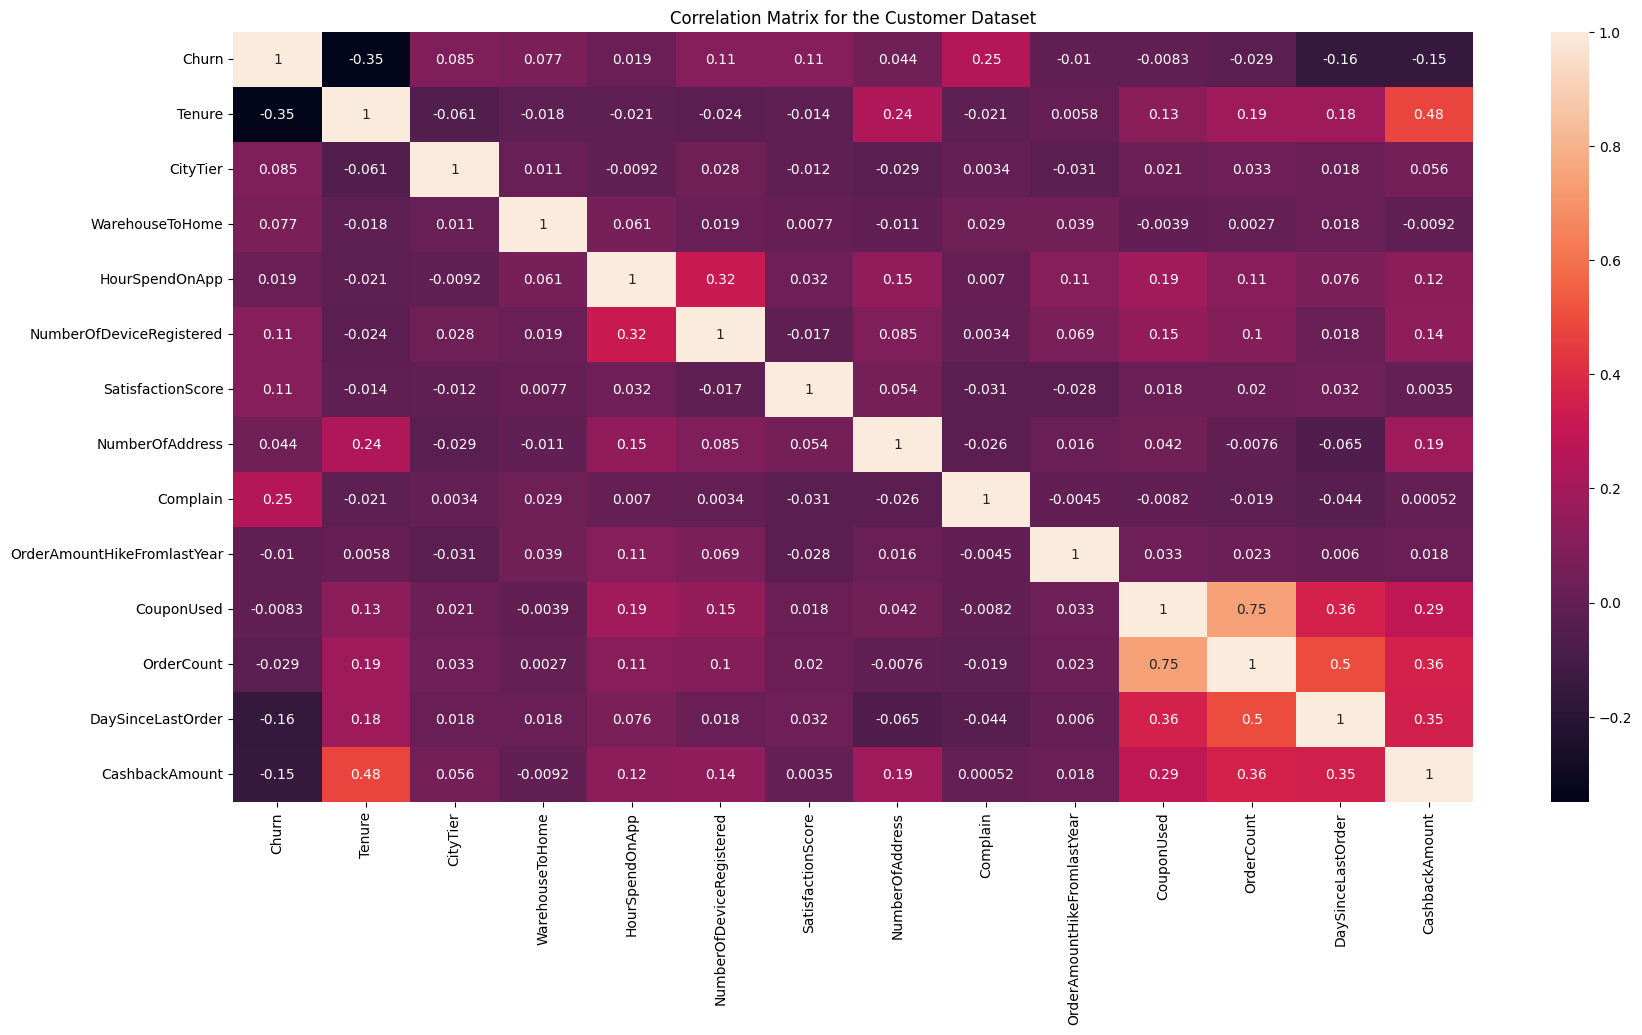

In [34]:
plt.figure(figsize=(20,10))
sns.heatmap(data.drop('CustomerID',axis=1).corr(), annot=True)
plt.title("Correlation Matrix for the Customer Dataset")
plt.show()

Findings
From the Analysis

* The Tenure, Days since last order, cashback amount, and warehouse to home features have outliers, but the outliers don't have huge impact on tree models, which will be my final model so I will keep them.
* Most of the customers spend 3 hours on the app, and 94.75% of the customers spend between 2 and 4 hours on the app
* Single people have higher churn rate than other Marital Status
* Customers with complain have higher churn rate than customers without complain
* From the scatterplot there is a relationship between tenure and the churn rate as there is a churn rate of 0.5 between 4 and 5 Tenure

## Data processing 

In [35]:
data = data.drop(['churn status'],axis=1)

In [36]:
#count the number of missing values across each columns
data.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [37]:
#count the total number of missing values in the dataset
print(f'The number of missing values: {data.isnull().sum().sum()}')
#count the number of rows with missing values
print(f'The number of rows with missing values: {data[data.isnull().any(axis=1)].shape[0]}')

The number of missing values: 1856
The number of rows with missing values: 1856


### Plot the missing values in all columns, using missingness matrix

In [52]:
def Plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum()!=0:
        na_df =(df.isnull().sum()/len(df))*100
        na_df = na_df.drop(na_df[na_df==0].index).sort_values(ascending=True)
        missing_data =pd.DataFrame({"Missing Ration %" : na_df})
        missing_data.plot(kind="barh")
        plt.show()
    else:
        print("No Null Value found")

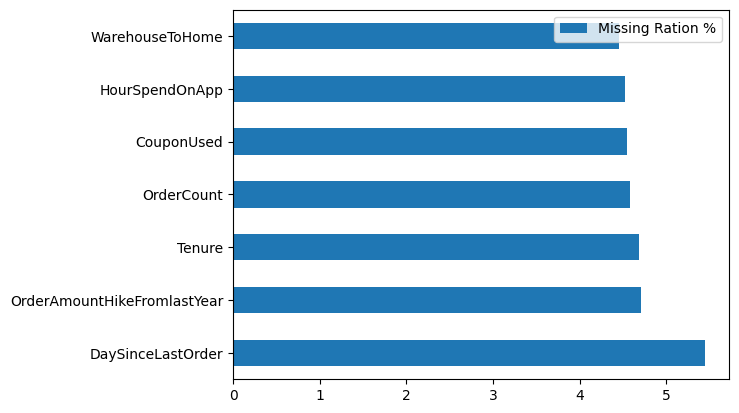

In [51]:
Plot_nas(data)

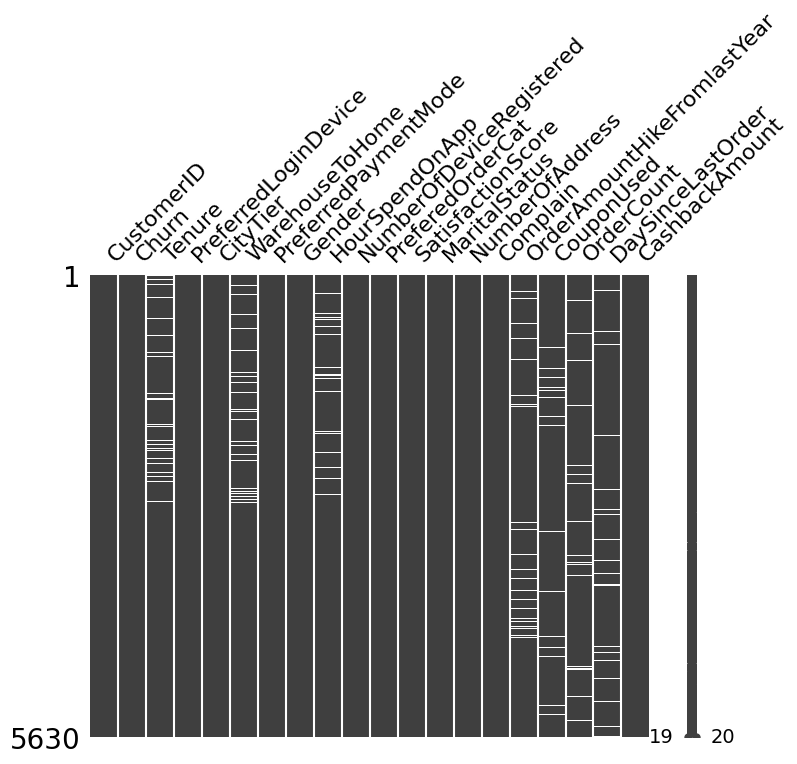

In [94]:
#plot the missingness matrix
msno.matrix(data, figsize=(8,6))
plt.show()

The missing values do not follow any pattern, they are missing completely at random(MCAR)

After sorting the data by all the columns, I found that sorting by the CashbackAmount columns creates a pattern between the missing values and the CashbackAmount columns, which identifies the missingness as missing at random(MAR)

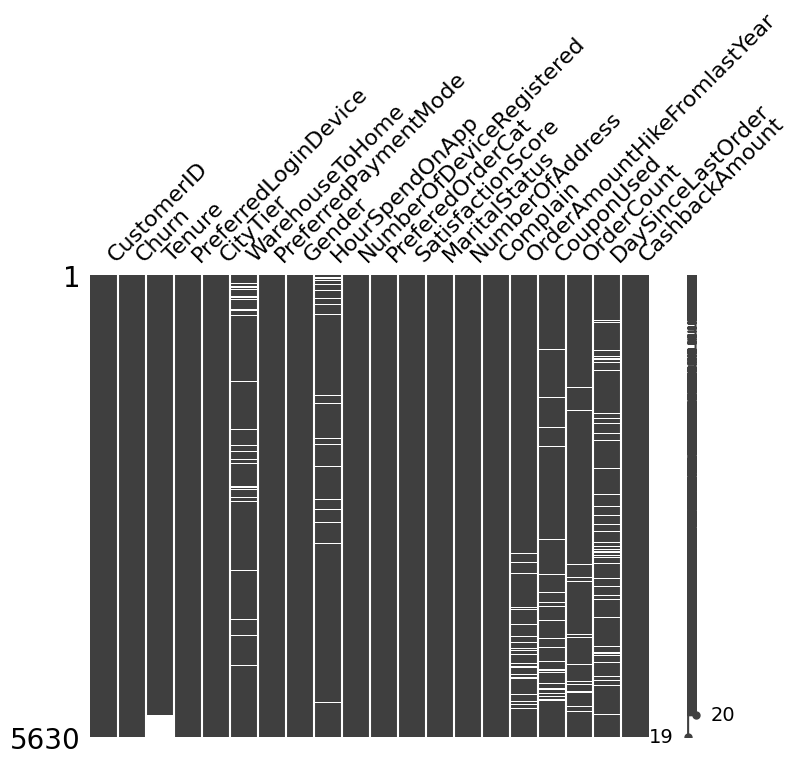

In [95]:
#plot the missingness matrix of sorted data
msno.matrix(data.sort_values(by='Tenure'), figsize=(8,6))
plt.show()

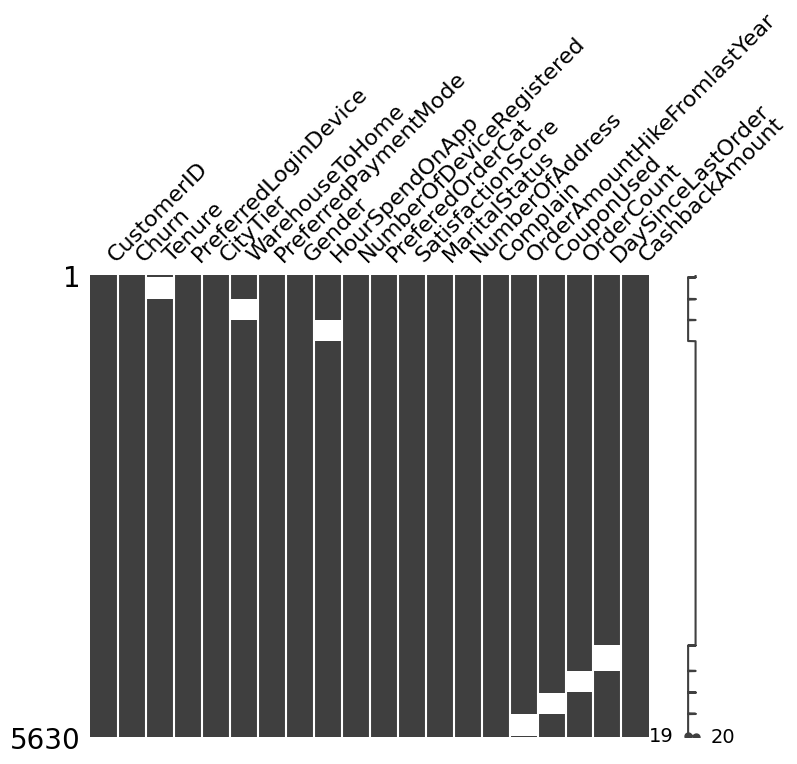

In [96]:
#plot the missingness matrix of sorted data
msno.matrix(data.sort_values(by='CashbackAmount'), figsize=(8,6))
plt.show()

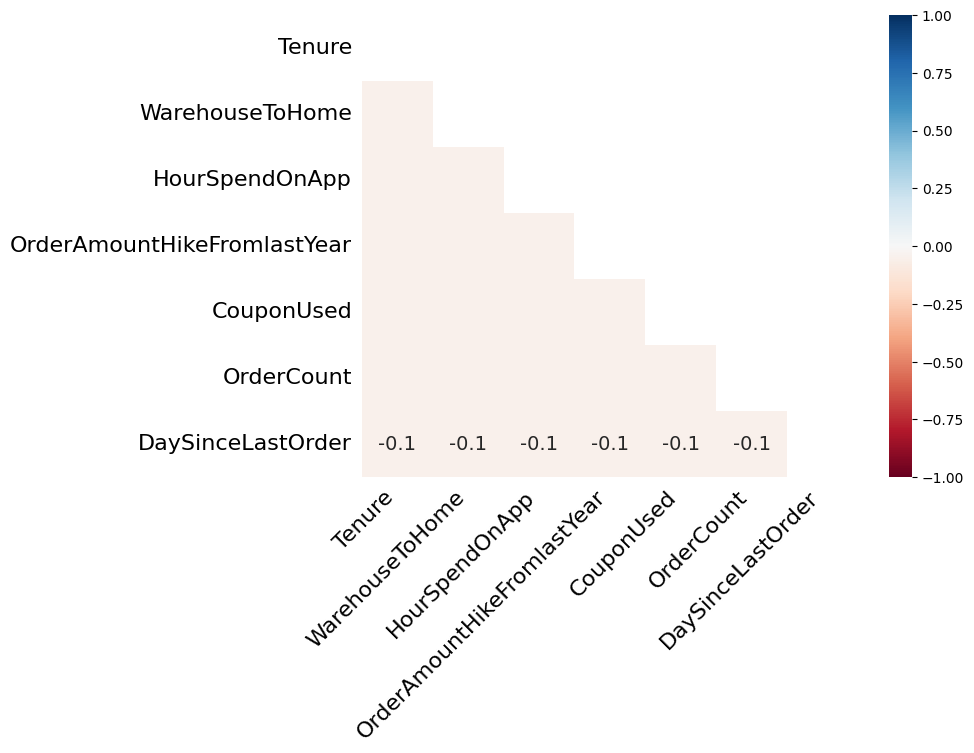

In [97]:
## Identifying relationships between missing values in columns
#plot heatmap of missing values
msno.heatmap(data,figsize=(8,6))
plt.show()

### Handling the missing values

Since the missingness is MAR, and the missing values are much, I will impute the missing values instead of dropping the missing value rows or columns.

For imputing the missing values, I will use the fancyimpute library, and use the IterativeImputer class to impute the missing values. The imputation will be done in a pipeline in the model selection section

### Categorical Encoding

Here I will encode the categorical variables as numeric variables, since machine learning algorithms work on numbers and not text. I will use the pandas get_dummies function which applies one-hot encoding to all the variables passed to it.

In [98]:
cat_data = data.select_dtypes(include='object')
cat_data

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,Mobile Phone,Debit Card,Female,Laptop & Accessory,Single
1,Phone,UPI,Male,Mobile,Single
2,Phone,Debit Card,Male,Mobile,Single
3,Phone,Debit Card,Male,Laptop & Accessory,Single
4,Phone,CC,Male,Mobile,Single
...,...,...,...,...,...
5625,Computer,Credit Card,Male,Laptop & Accessory,Married
5626,Mobile Phone,Credit Card,Male,Fashion,Married
5627,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
5628,Computer,Credit Card,Male,Laptop & Accessory,Married


In [99]:
#encode categorical variables and add it to the normal dataset
encoded = pd.get_dummies(cat_data,drop_first=True)

data_enc = pd.concat([data.drop(cat_data.columns, axis=1), encoded], axis=1)
data_enc.drop('CustomerID', axis=1,inplace=True)

In [100]:
encoded.head()

,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,PreferredPaymentMode_COD,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1
2,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
4,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [101]:
data_enc.head()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,4.0,3,6.0,3.0,3,2,9,1,11.0,...,0,0,0,0,1,0,0,0,0,1
1,1,NaN,1,8.0,3.0,4,3,7,1,15.0,...,0,1,1,0,0,1,0,0,0,1
2,1,NaN,1,30.0,2.0,4,3,6,1,14.0,...,0,0,1,0,0,1,0,0,0,1
3,1,0.0,3,15.0,2.0,4,5,8,0,23.0,...,0,0,1,0,1,0,0,0,0,1
4,1,0.0,1,12.0,NaN,3,5,3,0,11.0,...,0,0,1,0,0,1,0,0,0,1


### Model Development


* Firstly I will split the data into training and testing samples.
* I will make pipelines which will include all the preprocessing steps and the classifier.
* I will use 4 Classifiers; 2 linear classifiers, 2 tree classifiers to build the model.
* I will perform cross validation on the training samples, and use prediction of the testing sample to compare the models, and select the best model for hyperparameter tuning.

In [102]:
#selecting features and target variable, and splitting the data
X=data_enc.drop(['Churn'],axis=1)
y=data_enc['Churn']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

#cross validation
skfcv=StratifiedKFold(n_splits=5)

In [103]:
X.head()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,4.0,3,6.0,3.0,3,2,9,1,11.0,1.0,...,0,0,0,0,1,0,0,0,0,1
1,NaN,1,8.0,3.0,4,3,7,1,15.0,0.0,...,0,1,1,0,0,1,0,0,0,1
2,NaN,1,30.0,2.0,4,3,6,1,14.0,0.0,...,0,0,1,0,0,1,0,0,0,1
3,0.0,3,15.0,2.0,4,5,8,0,23.0,0.0,...,0,0,1,0,1,0,0,0,0,1
4,0.0,1,12.0,NaN,3,5,3,0,11.0,1.0,...,0,0,1,0,0,1,0,0,0,1


### Logistic Regression

In [104]:
#Build logistic regression pipeline
log_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('logreg',LogisticRegression())])




In [105]:
#cross validate logistic regression model
print(f"Cross validation score for Logistic Regression: {np.mean(cross_val_score(log_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Logistic Regression: 0.6316720359392626


Test score for Logistic Regression: 0.6409495548961425
Training score for Logistic Regression: 0.6497305619707466


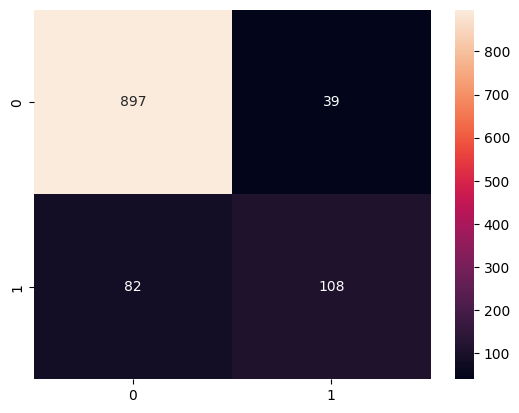

In [106]:
#use logistic regression pipeline to predict test sample
log_pipe.fit(X_train,y_train)
print(f"Test score for Logistic Regression: {f1_score(y_test, log_pipe.predict(X_test))}")
print(f"Training score for Logistic Regression: {f1_score(y_train, log_pipe.predict(X_train))}")
log_mat = confusion_matrix(y_test, log_pipe.predict(X_test))
sns.heatmap(log_mat, annot=True,fmt="g")
plt.show()

### Linear Discriminant Analysis

In [107]:
#Build LinearDiscriminantAnalysis pipeline
lda_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('lda',LinearDiscriminantAnalysis())])

#cross validate LinearDiscriminantAnalysis model
print(f"Cross validation score for LinearDiscriminantAnalysis: {np.mean(cross_val_score(lda_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for LinearDiscriminantAnalysis: 0.5911106748453845


Test score for LinearDiscriminantAnalysis: 0.6358024691358025
Training score for LinearDiscriminantAnalysis: 0.6093874303898169


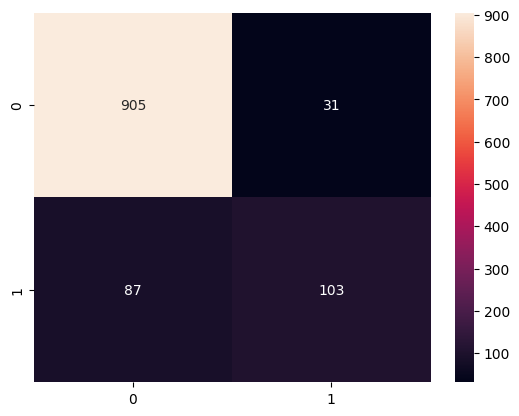

In [108]:
#use LinearDiscriminantAnalysis pipeline to predict test sample
lda_pipe.fit(X_train,y_train)
print(f"Test score for LinearDiscriminantAnalysis: {f1_score(y_test, lda_pipe.predict(X_test))}")
print(f"Training score for LinearDiscriminantAnalysis: {f1_score(y_train, lda_pipe.predict(X_train))}")
lda_mat = confusion_matrix(y_test, lda_pipe.predict(X_test))
sns.heatmap(lda_mat, annot=True,fmt="g")
plt.show()

### Random Forest

In [109]:
#Build Random Forest pipeline
rf_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('rfmodel',RandomForestClassifier())])

In [110]:
#cross validate Random Forest model
print(f"Cross validation score for Random Forest: {np.mean(cross_val_score(rf_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Random Forest: 0.8590834483868675


Test score for Random Forest: 0.9061662198391421
Training score for Random Forest: 1.0


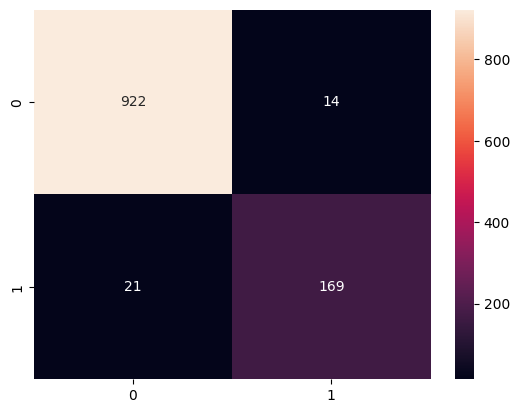

In [111]:
#use Random Forest pipeline to predict test and train sample
rf_pipe.fit(X_train,y_train)
print(f"Test score for Random Forest: {f1_score(y_test, rf_pipe.predict(X_test))}")
print(f"Training score for Random Forest: {f1_score(y_train, rf_pipe.predict(X_train))}")
rf_mat = confusion_matrix(y_test, rf_pipe.predict(X_test))
sns.heatmap(rf_mat, annot=True,fmt="g")
plt.show()

In [112]:
#Build XGBoost pipeline
xgb_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('xgb',XGBClassifier(verbosity=0,use_label_encoder=False))])

#cross validate XGBoost model
print(f"Cross validation score for XGBoost: {np.mean(cross_val_score(xgb_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")


Cross validation score for XGBoost: 0.8860940695783341


Test score for XGBoost: 0.9259259259259259
Training score for XGBoost: 1.0


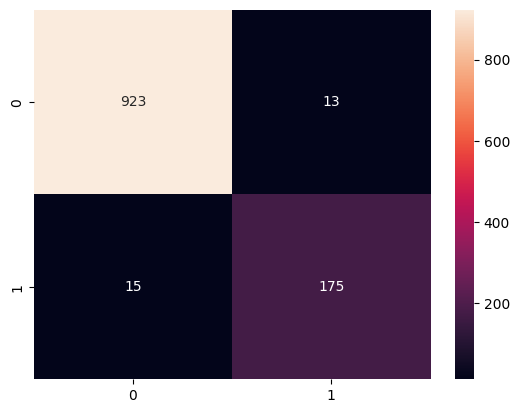

In [113]:
#use XGBoost pipeline to predict test and train sample
xgb_pipe.fit(X_train,y_train)
print(f"Test score for XGBoost: {f1_score(y_test, xgb_pipe.predict(X_test))}")
print(f"Training score for XGBoost: {f1_score(y_train, xgb_pipe.predict(X_train))}")
xgb_mat = confusion_matrix(y_test, xgb_pipe.predict(X_test))
sns.heatmap(xgb_mat, annot=True, fmt="g")
plt.show()

### Hyperparameter Tuning


The tree models performed better than the linear models, although we can see that the tree models overtitted as their training f1-score is higher than their testing f1-score.

So I will tune the hyperparameters to reduce overfitting and improve test performance.

I will use BayesSearchCV from the scikit-optimize library for tuning the hyperparameters

In [114]:
#create hyperparameter search space
space={'xgb__eta': (0.01,0.3),
       'xgb__max_depth': (5,11),
      'xgb__subsample': (0.4,1),
      'xgb__n_estimators': (100,250),
      'xgb__gamma':(0,5),
      'xgb__colsample_bytree':(0.4,1),
      'xgb__min_child_weight': (0.3,1)}

In [115]:
#create BayesSearchCV object
search=BayesSearchCV(xgb_pipe,search_spaces=space,n_jobs=-1,cv=skfcv, scoring='f1')

In [117]:
#fit the object to the data
search.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=Pipeline(steps=[('imputer',
                                         IterativeImputer(random_state=0)),
                                        ('scaler', StandardScaler()),
                                        ('xgb',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       early_stopping_rounds=None,
                                                       enable_categori...
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       predictor=None,
                                                       random_state=None, ...))]),
              n_jobs=-1, scoring='f1',
              search_spaces={'xgb__colsample_bytree': (0.4, 1),
                             'xgb__eta': (0.01, 0.3), 'xgb__gamma': (0, 5),
                             'xgb__max_depth': (5, 11),
                             'xgb__min_child_weight': (0.3, 1),
                             'xgb__n_estimators': (100, 250),
                             'xgb__subsample': (0.4, 1)})

In [118]:
#print the best cv score and the best parameters
print(search.best_score_)
print(search.best_params_)

0.9017461064983179
OrderedDict([('xgb__colsample_bytree', 1.0), ('xgb__eta', 0.2057794357300749), ('xgb__gamma', 0), ('xgb__max_depth', 11), ('xgb__min_child_weight', 0.3), ('xgb__n_estimators', 250), ('xgb__subsample', 0.8382388940088803)])


0.9267015706806283


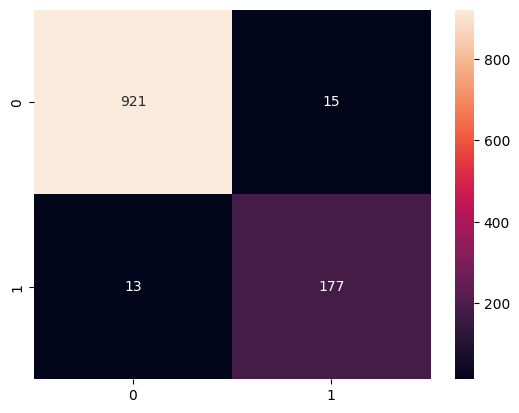

In [119]:
#use the best model parameters to predict the test sample and print the results
best_model=search.best_estimator_
print(f1_score(y_test,best_model.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt="g")
plt.show()

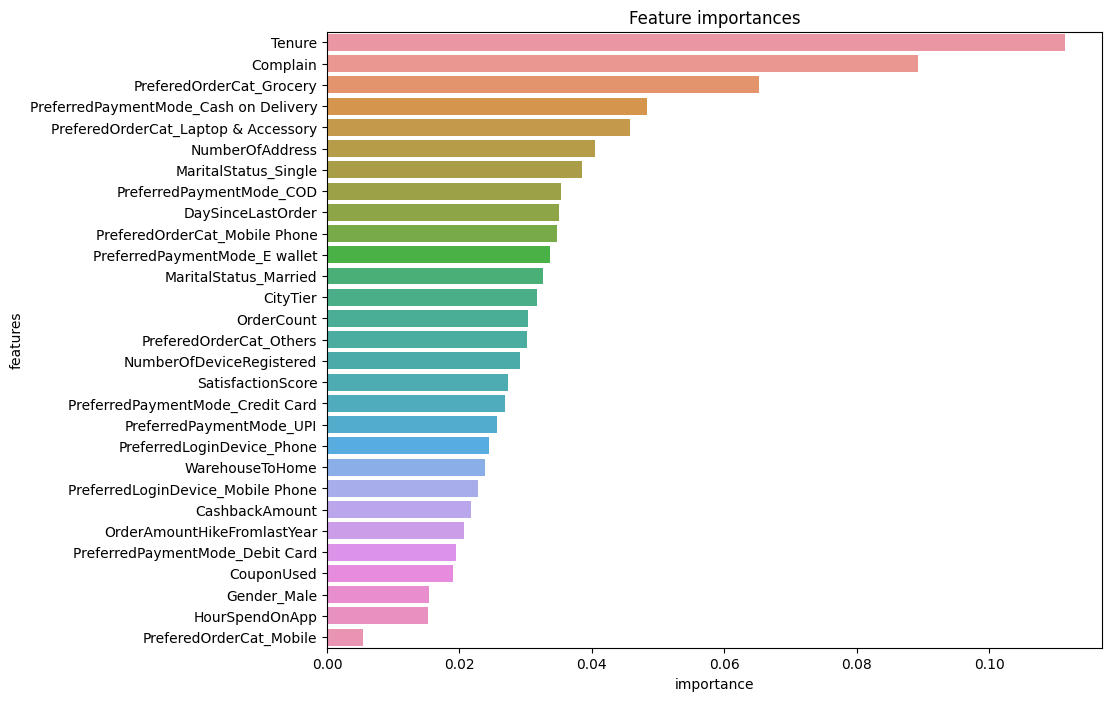

In [120]:
feature_importance=pd.DataFrame(search.best_estimator_[2].feature_importances_, columns=['importance'])
feature_importance['features'] = X_train.columns

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='features', data=feature_importance.sort_values(by='importance', ascending=False))
plt.title('Feature importances')
plt.show()

### Conclusion


After building the 4 models, the tree classifiers performed better than the linear classifiers, with XGBoost performing best with a test f1-score of 92.59%. I then tuned the xgboost hyperparameters which resulted in a 1.2% increase in cross validation score, and a 1.1% increase in test score.

The true positive rate is 93.68% which means we can correctly identify 93% of the customers that will leave.

The precision is also 93.68% which means out of the predicted customers that will leave, 93% will actually leave